## Demo for the Simulation of Interferometry Data and Time-Delay Interferometry
This demonstration introduces the basic concepts concerning the laser interferometric measurements and time-delay interferometry (TDI). 
We briefly showcase the procedure from raw data to the TDI data, which is further used in the analysis of gravitational wave (GW) signals. 
The simulation in this demonstration does not include GW signals, but instead includes noises and other effects that affects the data. 
In order to compare with theoretical analysis, most of the noises are generated according to the "nominal" models of Taiji. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import * 

# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set logging and multiprocessing

run this cell only ONCE

In [2]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 12


## 1. Simulate laser interferometric measurements

<img src="../Figures/constellation.png" alt="Drawing" style="width: 500px;" align="center">

There are two movable optical sub-assemblies (MOSAs) symmetrically installed on each spacecraft (SC).
MOSA is a structure composed of an optical bench, a laser source, a telescope, and a gravitaional reference sensor hosting the test-mass.
Each MOSA is labeled by $ij$ ($ij \in \{12, 23, 31, 21, 32, 13\}$), with $i$ being the index of spacecraft (SC) carrying this MOSA, and $j$ the index of distant SC that transmits lasers with this MOSA. 

All the interferometric measurements used for GW detection are taken on the optical benches [Ref: [ArXiv:2212.05351](http://arxiv.org/abs/2212.05351)].
Specifically, the interspacecraft interferometer (ISI) mixes the local beam with the distant beam (coming from the distant MOSA); 
the test-mass interferometer (TMI) mixes the local and adjacent beams, after it has bounced on the local test mass;
and the reference interferometer (RFI) mixes the local and adjacent beams without interaction with the test mass (In above figure: $s$ -> ISI, $\tau$ -> RFI, $\varepsilon$ -> TMI).

Moreover, for the purposes of clock noise reduction and inter-spacecraft ranging, etc., "sidebands" are created by modulating clock signals to the lasers, resulting in an additional sideband interferometric measurement for each interferometer. 
We label the "original" interferometry with subscript "c" ("c" for "carrier"), and the "sideband" interferometry with "sb" ("sb" for "sideband").

In summary, there are 6 laser interferometric measurements on ${\rm MOSA}_{ij}$:  
- inter-spacecraft (scientific) interferometer, carrier: ${\rm ISI}_{c, ij}$
- inter-spacecraft (scientific) interferometer, sideband: ${\rm ISI}_{sb, ij}$
- test-mass interferometer, carrier: ${\rm TMI}_{c, ij}$
- test-mass interferometer, sideband: ${\rm TMI}_{sb, ij}$
- reference interferometer, carrier: ${\rm RFI}_{c, ij}$
- reference interferometer, sideband: ${\rm RFI}_{sb, ij}$ 

The results of laser interferometry are read out by the phasemeters, which output the instantanous frequencies of interfered lasers.
Therefore we simulate all the 6 $\times$ 6 data streams in the frequency (Hz) unit.
<details>
<summary>Why frequency not phase?</summary>

>See https://arxiv.org/pdf/2212.05351#page=4.07

</details>

Each data stream is a time series uniformly spaced in time. 
For the sake of understanding and numerical simulation, the laser interferometric data are usually regarded as the sum of two parts [Ref: [PhD Thesis of O. Hartwig](https://repo.uni-hannover.de/items/4afe8e21-39a1-49a9-a85d-996e1c5dbe30)]. 
One is a $\sim$ MHz order slow-varying "offset" part, and the other is a $\sim$ Hz order jittering "fluctuation" part. 
The former includes the effects of laser locking schemes, the frequency plans, the doppler effects due to orbital motions, etc., and the latter is the combination of various noises and GW signals. 
Note that this is only an artificial division and in realistic detection we only have access to the sum of them. 
The separation of these two parts is only possible after a "detrending" process. 

<details>
<summary> A few words about laser locking and frequency plan: </summary>

>To maintain the best performance of phasemeters, all the interferometric measurements should be controlled within the 5 MHz to 25 MHz range. 
This is realized by the so-called "laser locking" technique and by setting a "frequency plan". 
The latter should be determined by the orbital motion of SCs. An algorithm for the search of frequency plan can be found at 
[Ref: [PhysRevD.110.042002](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.042002)].

>Laser locking would make the output of other 5 laser sources dependent on the "primary" one, and hence affect all the raw interferometric measurements. 
Yet, whether the lasers are locked or all the lasers are independent would not affect the science data after TDI combination. 
Users may compare the TDI results of "fplan=fplan" and "fplan=None" to verify this statement.

</details>


### 1.1 Simulate the offset part

#### data settings 

In [4]:
fsample = 1 / 10000 # the sampling rate, default is 4 Hz. Here we set a (unrealistic) low sampling rate since this part is slow-varying. 
data_time = 110 * DAY # the time duration of simulation. The MicroSate orbit has a max length of 110 days, and simulation based on this orbit should not exceed this limit.
size = int(data_time * fsample) # size of the simulated time series. 
interp_order = 15 # interpolation order used to calculate the "delays", default is 31. We set a relative low order since this part is slow-varying. 

#### initialize the models of orbit, noises and clock drifts

In [5]:
# initialize orbit model from orbit data file 
tstart = 0. # the start time of simulation relative to initial time of orbit, default is 0 second. 
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', tstart=tstart) 

# set the drifts of lasers and clocks
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 

# initialize the models of basic instrumental noises 
noise = InstrumentalPSDs(L=L_nominal) 

### simulate interferometric data 
After the simulation is complete, the ``Interferometer`` object can output interferometric data in different "modes". 
Two of them might be most frequently used: 
- decomposed: output the fluctuation part (e.g. sci_c, sci_sb, ...) and offset part (e.g. a is the offset part for sci_c, b is the offset part for ref_c) separately, namely the data is perfectly detrended;
- total: output the total data (e.g. sci_c, sci_sb, ...).

We use the abbrevation "sci_" since ISI is also knwon as "science interferometer" in the literature. 

If no clock deviations are set, the data will be simulated relative to the proper times of SCs. 
For the sake of further astrophysical data anlysis, one should synchronize the data to a "global" time frame, such as the Barycenter coordinate time (TCB) frame.
Function ``TPStoTCB`` simulates this process, assuming that the relativistic effects can be pefectly measured and corrected. 

In [6]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime', # the time frame of data, 'ProperTime' for the proper times of SCs, 'ClockTime' for the times of on-board clocks (with clock drifts and jitters), default is "ProperTime".
    acc_noise=False, # switch of acceleration noise, default is True (this default value also applies to other noises). 
    ro_noise=False, # switch of readout noise
    laser_noise=False, # switch of laser frequency noise 
    clock_noise=False, # switch of clock noise 
    ob_noise=False, # switch of optical bench displacement noise 
    bl_noise=False, # switch of fibre backlink noise 
    op_noise=False, # switch of optical path noise (all optical paths)
    ranging_noise=False, # switch of pseudo ranging noise 
    modulation_noise=False, # switch of sideband modulation noise 
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None, # interface for the GW signals, default is None. 
    fplan=fplan, # set laser locking scheme and frequency plan, default is the "built-in" fplan, which is designed for the MicroSate orbit. 
    order=interp_order, 
    pool=pool,
    clean_memory=True, # whether to clean some intermediate variables to save memory, default is True. 
    )

# simulate interferometric measurements 
ifo.SimulateInterferometers()

# save data to a dictionary 
m = ifo.OutputMeasurements(mode='decomposed') 

ifo.clean() # release memory by erasing the simulation results.  

# convert the time frame of data to TCB
m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

# show the keys of dictionary 
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 0.0001 Hz.
INFO:Triangle.Interferometer:size = 950
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ProperTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Triangle.Interferometer:Proper delays generated.
INFO:Triangle.Interferometer:Generating clock offsets.
INFO:Triangle.Interferometer:Clock offsets generated.
INFO:Triangle.Interferometer:Generating unlocked sources.
INFO:Triangle.Interferometer:unlocked sources generated.
INFO:Triangle.Interferometer:Generating locked sources.
INFO:Triangle.Interferometer:Locked sources generated.
INFO:Tria

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### visualize light travel times 
The inter-spacecraft light travel times (LTTs), also known as "delays" or "armlengths", are crucial for the simulation and TDI processing. 
We calculate LTTs to the 1PN order according to the formalism of [Ref. [PhysRevD.72.122003](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.72.122003)].

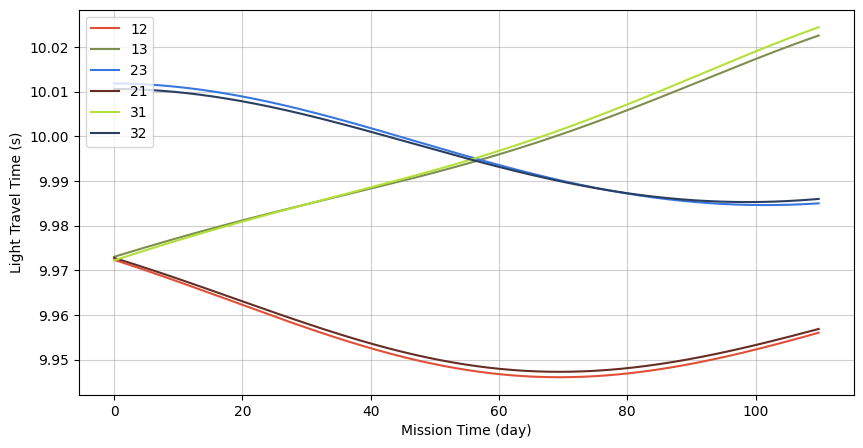

In [7]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m1['time'][key[0]] / DAY, m1['ltt'][key], color=MOSA_colors[key], label=key)
plt.grid(which='major', alpha=0.6)
plt.xlabel('Mission Time (day)')
plt.ylabel('Light Travel Time (s)')
plt.legend(loc="upper left")

#### visualize the offset MHz part
Here we show the carrier of inter-spacecraft interferometer as an example.

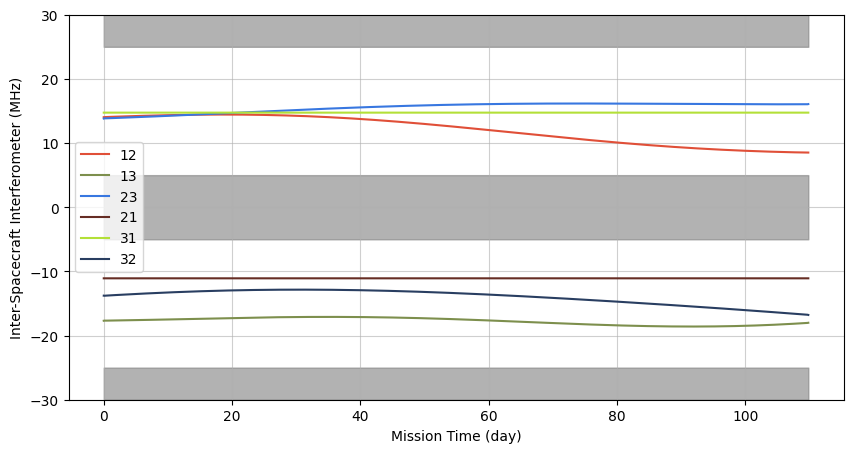

In [8]:
plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    plt.plot(m1['time'][key[0]] / DAY, m1['a'][key] / 1e6, color=MOSA_colors[key], label=key)
plt.fill_between(m1['time'][key[0]] / DAY, 25, 30, color='grey', alpha=0.6)
plt.fill_between(m1['time'][key[0]] / DAY, -30, -25, color='grey', alpha=0.6)
plt.fill_between(m1['time'][key[0]] / DAY, -5, 5, color='grey', alpha=0.6)
plt.grid(which='major', alpha=0.6)
plt.xlabel('Mission Time (day)')
plt.ylabel('Inter-Spacecraft Interferometer (MHz)')
plt.ylim(-30, 30)
plt.legend()

### 1.2 Simulate the fluctuation part 
In this section, we simulate the fluctuation part of data, considering the following noise sources:

the "primary" noises (which should be suppressed by TDI): 
- laser frequency noise
- clock noise 
- optical bench displacement noise 

the "secondary" noises (which will be the instrumental noise floor for GW detection):
- interferometer readout noise (including shot noise)
- test-mass acceleration noise

The default amplitudes of noises can be found in the ``Triangle.Constants`` module. 
For the sake of illustration, by default we ground all the optical metrology system noises (various readout noises and optical path noises) into the readout noise of ISI, which is the convention adopted by most of the literatures on space-based GW data analysis.
One should notice that this convention is correct only in the sense of overall noise amplitude. See Demo 2 for more details about the noise types. 

In [9]:
fsample = 10
data_time = 100000
size = int(data_time * fsample)
interp_order = 31 

In [10]:
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB', tstart=10.*DAY) # here we start from the 10th day 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

To include the clock noise, one should not only turn the switch "clock_noise" on, but also set the "time_frame" to "ClockTime".

Once again we output the results in the "decomposed" mode.


In [11]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ClockTime', # this time clock noise is included, so we set time_frame = 'ClockTime' and clock_noise = True
    acc_noise=True,
    ro_noise=True, 
    laser_noise=True, 
    clock_noise=True, 
    ob_noise=True,
    bl_noise=False, 
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=None,
    fplan=fplan,
    order=interp_order, 
    pool=pool,
    clean_memory=True, 
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') # we assume perfect detrending
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) # this function only deals with the drifts of proper times relative to TCB.
m1.keys()

INFO:Triangle.Interferometer:Simulating data with sampling frequency 10 Hz.
INFO:Triangle.Interferometer:size = 1000000
INFO:Triangle.Interferometer:Set frequency plan.
INFO:Triangle.Interferometer:time frame is ClockTime
INFO:Triangle.Interferometer:Noise types:
INFO:Triangle.Interferometer:	acc_noise
INFO:Triangle.Interferometer:	ro_sci_c_noise
INFO:Triangle.Interferometer:	ro_sci_sb_noise
INFO:Triangle.Interferometer:	ro_ref_c_noise
INFO:Triangle.Interferometer:	ro_ref_sb_noise
INFO:Triangle.Interferometer:	ro_tm_c_noise
INFO:Triangle.Interferometer:	laser_noise
INFO:Triangle.Interferometer:	ob_noise
INFO:Triangle.Interferometer:	clock_noise
INFO:Triangle.Interferometer:No GW signal.
INFO:Triangle.Interferometer:Generating basic instrumental noises.
INFO:Triangle.Interferometer:Basic instrumental noises generated.
INFO:Triangle.Interferometer:Generating proper times.
INFO:Triangle.Interferometer:Proper time generated.
INFO:Triangle.Interferometer:Generating proper delays.
INFO:Trian

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

#### plot the ASDs of ${\rm ISI}_{c, ij}$
Under the fiducial laser locking scheme, 2 of the ISIs are used for locking (hence noiseless), and others are dominated by laser frequency noises. 
Besides, all the other 5 lasers are correlated to the "primary" one. Setting "fplan=None" would make all the 6 lasers independent of each other, and every ISI output will be dominated by laser frequency noises. 

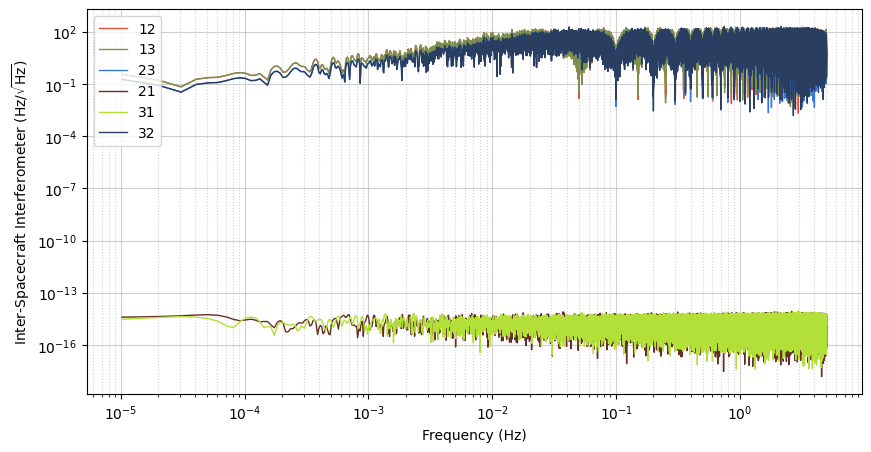

In [12]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop_points = int(1000 * fsample) # Interpolation is widely used in the simulation, thus data at the boundaries might be invalid. Dropping the first and last 1000s should be a safe practice. 

plt.figure(figsize=(10, 5))
for key in MOSA_labels:
    f, xf = PSD_window(m1['sci_c'][key][drop_points:-drop_points], m1['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
    plt.loglog(f, np.sqrt(xf), color=MOSA_colors[key], label=key, linewidth=1)

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Inter-Spacecraft Interferometer ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc="upper left")

## 2. Simulate TDI processing 
In order to reduce the aforementioned "primary" noises, the complete TDI processing includes 4 steps: 
- construct the intermediate variable $\xi_{ij}$ which are free of optical bench displacement noise
- construct the intermediate varibale $\eta_{ij}$ to reduce half of the laser noises 
- combine TDI channel to reduce all the laser noises. This step differs for different TDI schemes (e.g. Michelson type $\{X, Y, Z\}$ channels, Sagnac type $\{\alpha, \beta, \gamma\}$ channels.)
- calculate and subtract the clock noise correction term 

The choice of TDI channel can be specified in multiple ways, and the simplest one is by using the channel's name, e.g. "X2". Other methods for specifying TDI channels will be shown in Demo 2. In this Demo, we use the second-generation Michelson X channel as an example, which can be expressed as 
$$X_2 = \left(1 - \bm{\rm D}_{131} - \bm{\rm D}_{13121} + \bm{\rm D}_{1213131}\right) \left(\eta_{12}+\bm{\rm D}_{12}\eta_{21}\right)
 - \left(1 - \bm{\rm D}_{121} - \bm{\rm D}_{12131} + \bm{\rm D}_{1312121}\right) \left(\eta_{13}+\bm{\rm D}_{13}\eta_{31}\right) $$
where 
$$\bm{\rm D}_{ij}f(t) \equiv f\left(t - d_{ij}\right)$$
and the multiple delay operator $\bm{\rm D}_{i_1i_2...i_{n-1}i_n}f(t)$ is defined as $f(t)$ acted upon by $\bm{\rm D}_{i_{n-1}i_n}$, $\bm{\rm D}_{i_{n-2}i_{n-1}}$ ... successively. 

Besides, For TDI processing with the frequency unit, one should replace the original delay operator by the "doppler" delay operator [Ref: [PhysRevD.104.023006](https://doi.org/10.1103/PhysRevD.104.023006)]:
$$\dot{\boldsymbol{\rm D}}_{ij} f\ \equiv \left(1 - \dot{d}_{ij}\right) \boldsymbol{\rm D}_{ij} f$$

A ``TDI`` object can be initialzed by the following inputs:
- a dictionary that stores laser interferometric data
- a dictionary that stores the delays
- the sampling rate of data 
- the order of lagrange interpolation 

The conventional TDI algorithim deals with data that has already gone throuhg the "detrending" processing, i.e. only the fluctuation part is left. The inputs of this section are generated by the last one (1.2). 

In practice, prior to TDI processing, the "delays" should be obtained from a “ranging“ process that measures the inter-spacecraft LTTs $d_{ij}$ (denoting the time of laser propagating from SC j to SC i). 
The conventional TDI algorithm also requires that all measurements to be "synchronized" to a global time frame (such as TCB). 
Here we assume perfect ranging and synchronization. 



In [13]:
# initialize TDI
tdi_interp_order = 31 # the order of lagrange interpolation, default is 31. 
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=tdi_interp_order)

# calculate \xi_ij, the doppler argument decides whether to use the doppler delay operator 
tdi.CalculateXi(doppler=True, pool=pool)

# calculate \eta_ij 
tdi.CalculateEta(doppler=True)

# combine the 2nd generation Michelson X TDI channels 
tdi.CalculateBasicTDI(channel='X2', doppler=True)

tdi.measurements.keys()

INFO:Triangle.TDI:TDI channel X2 calculated.


dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2'])

In [14]:
# calculate the clock noise correction term 
tdi.CalculateClockTDI(channel='X2', channel_name='X2')

tdi.measurements.keys()

INFO:Triangle.TDI:clock correction for channel X2 calculated.


dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X2', 'X2_q'])

#### plot TDI results 
We compare the ASDs of raw data, the TDI data before clock noise reduction, and the TDI data after clock noise reduction. 
At high frequencies (about half order of magnitude near the Nyquist frequency), interpolation errors will dominate the TDI data stream [Ref: [PhysRevD.109.043040](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.109.043040)].  

For comparison, we also show the theoretical ASD of secondary noises, which is deduced based on the two-component noise model (i.e. only optical metrology system noise and test-mass acceleration noise). 

armlengths in second: {'12': 9.967162145692871, '13': 9.977509974643976, '23': 10.010963426474056, '21': 9.967803738554785, '31': 9.976997322247591, '32': 10.00979201944186}


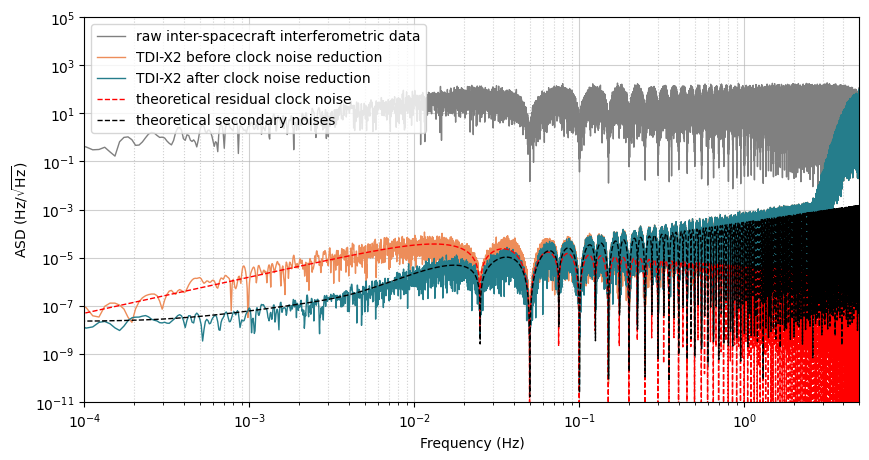

In [15]:
win = 'kaiser'
windict = dict(beta=28)
nbin = 1
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))

f, xf = PSD_window(m1['sci_c']['12'][drop_points:-drop_points], m['fsample'], nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color='grey', linewidth=1, label='raw inter-spacecraft interferometric data')

f, xf = PSD_window(tdi.measurements['X2'][drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=ORANGE, linewidth=1, label='TDI-X2 before clock noise reduction')

f, xf = PSD_window((tdi.measurements['X2'] - tdi.measurements['X2_q'])[drop_points:-drop_points], tdi.fsample, nbin=nbin, window_type=win, window_args_dict=windict)
plt.loglog(f, np.sqrt(xf), color=GREEN1, linewidth=1, label='TDI-X2 after clock noise reduction')

plt.loglog(f, np.sqrt(ResidualClockNoise(freqs=f, a=tdi.measurements["a"], b=tdi.measurements["b"], channel="X2")), color='red', linestyle="--", label="theoretical residual clock noise", linewidth=1)

# get armlengths to calculate the theoretical noise PSDs (use the armlengths at the median time should be sufficient for a short-duration data).
arms = dict()
arm_idx = int(len(m1['ltt']['12']) / 2.)
for k, v in m1['ltt'].items():
    arms[k] = v[arm_idx]
print("armlengths in second:", arms)
PSD = TDIPSDs()
PSD_X2 = PSD.PSD_X2_unequal(f, arms) # this function returns noise PSD in the fractional frequency difference unit 
plt.loglog(f, np.sqrt(PSD_X2) * F_LASER, color='k', linestyle='--', linewidth=1, label ='theoretical secondary noises')

plt.grid(which='major', alpha=0.6)
plt.grid(which='minor', alpha=0.6, linestyle=':')

plt.xlim(1e-4, 5)
plt.ylim(1e-11, 1e5)

plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD ' + r'${\rm (Hz/\sqrt{Hz})}$')

plt.legend(loc='upper left')

